In [2]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
infotable = f'/data01/homes/dipiano/E4/irf_random/crab/sim/merged_simulator_data.dat'

# dataset 
mapsname = '/data01/homes/dipiano/E4/irf_random/crab/regression_5sgm_5000sz.npy'
ds = np.load(mapsname, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Maps: {ds.keys()}")
print(f"DS dataset size: {len(ds['DS'])}")

Maps: dict_keys(['DS'])
DS dataset size: 5000


In [3]:
from astroai.tools.utils import split_regression_dataset

train_data, train_labels, test_data, test_labels = split_regression_dataset(ds, infotable, split=80, reshape=True, binning=250)

print(f"Train dataset: {len(train_data)}, {train_data.shape}")
print(f"Train labels: {len(train_labels)}, {train_labels.shape}")
print(f"\nTest dataset: {len(test_data)}, {test_data.shape}")
print(f"Test labels: {len(test_labels)}, {test_labels.shape}")

(4000, 250, 250) (4000, 2)
Train dataset: 4000, (4000, 250, 250, 1)
Train labels: 4000, (4000, 2)

Test dataset: 1000, (1000, 250, 250, 1)
Test labels: 6000, (6000, 2)


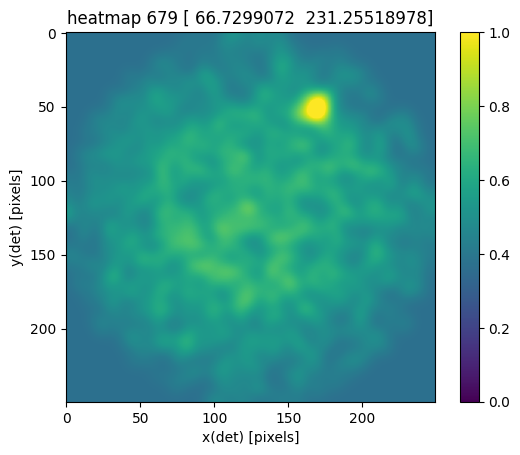

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
6678,crab_00679,679,0,300,300,147.422201,-48.275164,146.393742,-46.741922,1.683243,North_z20_0.5h_LST,2.5,8.748357


In [4]:
from astroai.tools.utils import plot_heatmap

idx = np.random.choice(range(len(train_data)))
plot_heatmap(train_data[idx], title=f'heatmap {idx} {train_labels[idx]}', show=True, save=False, save_name=None)

info = pd.read_csv(infotable, sep=' ', header=0).sort_values(by=['seed'])
info[info['seed']==idx]

### Check WCS to pixel conversion

In [5]:
from astroai.tools.utils import *

row = info[info['seed']==idx]
w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], point_ref=250/2+0.5, pixelsize=row['fov'].values[0]/250)
x, y = w.world_to_pixel(SkyCoord(row['source_ra'].values[0], row['source_dec'].values[0], unit='deg'))
x, y

(array(56.02790456), array(-29.27180053))

In [5]:
sky = w.pixel_to_world(x, y)
sky

<SkyCoord (ICRS): (ra, dec) in deg
    (120.40509421, 66.46544026)>